# Graphical Models

Graphical models combine aspects of graph theory, machine learning and statistics. We have already encountered graphical models incidentally in this course, in the form of directed acyclic graphs (DAGs), which we used to build Bayesian models, and also in the exploration of neural networks. Today we will dig a little deeper and explore probabilistic graphical models. Probabilistic graph models provide an intuitive way to express joint probability relationships. 

The **nodes** in a graph represent random variables and the **edges** between nodes represent a probabilistic relationship between variables.

Graphical models can either be directed (such as DAGs) or undirected (such as Markov random fields). We will focus mainly on the directed variety here.

## Encoding probabilistic models

In particular, we are interested in encoding discrete probability distributions. This is a simplification of the problem in many cases, but it makes the probelm easier to think about an describe.

Consider the model below, and in particular, the relationship between nodes B and C. We will draw our graphical models using the [NetworkX](https://networkx.github.io) package, which can be installed either via `pip` or `conda` depending on your setup:

    $ pip install networkx
    
    $ conda install networkx

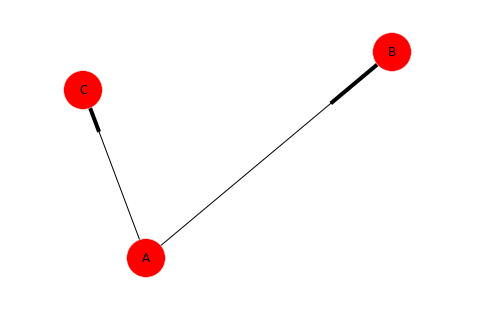

In [2]:
%matplotlib inline
import pylab as plt
import numpy as np
import pymc as pm
import networkx as nx

G = nx.DiGraph()

G.add_edges_from([('A', 'B'),('A','C')], weight=1)

pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=1500, edge_cmap=plt.cm.Reds)
nx.draw_networkx_labels(G, pos);

It is tempting to suggest that B and C are *independent* of one another, since there is no edge connecting the two. However, there is a **path** between the two nodes, via node A. In this case, B and C are *conditionally* independent, given the value of A.

Often the links in a DAG are interpreted as being causal, but this is not always correct. All the graph tells us are the conditional relationships among the nodes. For example:

$$Pr(A, B) = Pr(B | A) Pr(A)$$

As we are dealing here with discrete variables for each of the nodes, the distributions can be specified as a lookup table, which results in a conditional probability table. In Python, we can construct this as a `list` or an `array`; for example, node B might be specified by:

In [4]:
pB = [0.3, 0.7]

which will return a value of 0.3 if indexed by the value of node A (either `True` (1) or `False` (0)).

In [5]:
pB[True]

0.7

Nodes for which we know the true value are **observed** nodes, while those which are unknown are called **hidden** or **latent** nodes.

As with several of the methods introduced in this course, probabilistic graphical models are built upon very simple concepts, but can result in powerful learning tools.

## Bayesian Networks

When we endow the nodes of a directed acyclic graph with conditional probability tables, the result is a Bayesian network. Consider the following graphical model that probabilistically links four different patient states:

![cancer bayes net](http://d.pr/i/13AGg+)

Depending on what is observed, we can use the model for prediction, in a top-down manner, or for diagnosis, in a bottom-up manner.



{'B': <matplotlib.text.Text at 0x10feb6320>,
 'C': <matplotlib.text.Text at 0x110024f98>,
 'F': <matplotlib.text.Text at 0x11002b518>,
 'S': <matplotlib.text.Text at 0x11002ba58>}

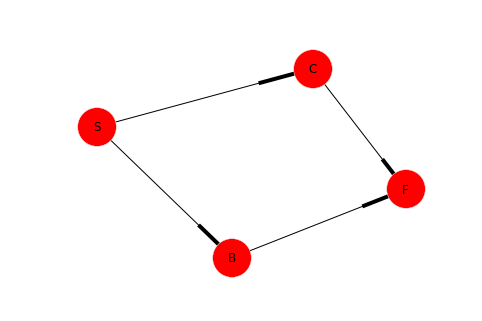

In [20]:
G = nx.DiGraph()

G.add_edges_from([('S', 'B'),('S','C'),('B','F'),('C','F')], weight=1)


val_map = {'S': 1.0,
                   'B': 0.5714285714285714,
                              'F': 0.0}

values = [val_map.get(node, 0.45) for node in G.nodes()]
red_edges = [('C','D'),('D','A')]
edge_colors = ['black' if not edge in red_edges else 'red' for edge in G.edges()]

pos=nx.spring_layout(G)
nx.draw(G,pos, node_size=1500,edge_color=edge_colors,edge_cmap=plt.cm.Reds)
nx.draw_networkx_labels(G,pos)

In [2]:
# Smoking  probabilities
S = [0.5, 0.5]

# Bronchitis probabilities
B = [[0.95, 0.05], # non-smoker
     [0.75, 0.25]] # smoker

# Lung cancer probabilities
C = [[0.99995, 0.00005], # non-smoker
     [0.003, 0.997]]     # smoker

# Fatigue probabilities
F = [[[0.95, 0.05],  # no bronchitis, no cancer
      [0.5, 0.5]],   # no bronchitis, cancer
     [[0.9, 0.1],    # bronchitis, no cancer
      [0.25, 0.75]]] # bronchitis, cancer

![bayes net](http://d.pr/i/1jpHZ+)

In [3]:
# X-ray mass probabilities
M = [[0.98, 0.02], # no cancer
     [0.4, 0.6]]   # cancer

In [2]:
import numpy as np
    
Pb = np.array([[0.5,0.5]])
Pr_b = np.array([[0.3,0.7],[0.8,0.2]])
Pa_b = np.array([[0.1,0.9],[0.5,0.5]])
Ps_ra = np.array([[0,1],[0.8,0.2],[0.6,0.4],[1,0]])

"""
P(b|ras)=P(b|ra)=P(ra|b)*P(b)/P(ra)=P(r|b)*P(a|b)*P(b)/P(ra)
r a    P(b)
T T    0.3*0.1*0.5/0.215=0.0698
T F    0.3*0.9*0.5/0.335=0.4030
F T    0.7*0.1*0.5/0.085=0.4118
F F    0.7*0.9*0.5/0.365=0.8630
"""

def pb_ras(values):
    if np.random.rand()<values[1]*values[2]*0.0698+values[1]*(1-values[2])*0.4030+(1-values[1])*values[2]*0.4118+(1-values[1])*(1-values[2])*0.8630:
        values[0]=1
    else:
        values[0]=0
    return values   

"""   
P(r|bas)=P(ras|b)*P(b)/P(bas)
        =(P(s|rab)*P(rab)/P(b))*P(b)/P(bas)
        =(P(s|rab)*P(rab))/P(bas)
       
P(bas)=P(b)*P(a|b)*(P(r|b)*P(s|ra)+P(~r|b)*P(s|~ra))
    b a s    P(bas)
    T T T    0.5*0.1*(0.3*0+0.7*0.6)=0.021
    T T F    0.5*0.1*(0.3*1+0.7*0.4)=0.029
    T F T    0.5*0.9*(0.3*0.8+0.7*1)=0.423
    T F F    0.5*0.9*(0.3*0.2+0.7*0)=0.027
    F T T    0.5*0.5*(0.8*0+0.2*0.6)=0.030
    F T F    0.5*0.5*(0.8*1+0.2*0.4)=0.220
    F F T    0.5*0.5*(0.8*0.8+0.2*1)=0.210
    F F F    0.5*0.5*(0.8*0.2+0.2*0)=0.040




P(r|bas) =(P(s|rab)*P(rab))/P(bas)
         =(P(s|ra)*P(r|b)*P(a|b)*P(b))/P(bas)

b a s    P(r)
T T T    0                     =0
T T F    1*0.3*0.1*0.5/0.029   =0.5172
T F T    0.8*0.3*0.9*0.5/0.423 =0.2553
T F F    0.2*0.3*0.9*0.5/0.027 =1
F T T    0                     =0
F T F    1*0.8*0.5*0.5/0.220   =0.9091
F F T    0.8*0.8*0.5*0.5/0.210 =0.7619
F F F    0.2*0.8*0.5*0.5/0.040 =1
"""


def pr_bas(values):
    y=np.random.rand(1)
    if np.random.rand()<values[0]*values[2]*(1-values[3])*0.5172+values[0]*(1-values[2])*values[3]*0.2553+values[0]*(1-values[2])*(1-values[3])+(1-values[0])*values[2]*(1-values[3])*0.9091+(1-values[0])*(1-values[2])*values[3]*0.7619+(1-values[0])*(1-values[2])*(1-values[3]):
        values[1]=1
    else:
        values[1]=0
    return values



"""   
P(a|brs)=P(ras|b)*P(b)/P(brs)
        =(P(s|rab)*P(rab)/P(b))*P(b)/P(brs)
        =(P(s|rab)*P(rab))/P(brs)
       
P(brs)=P(b)*P(r|b)*(P(a|b)*P(s|ra)+P(~a|b)*P(s|r~a))
    b r s    P(brs)
    T T T    0.5*0.3*(0.1*0+0.9*0.8)=0.108
    T T F    0.5*0.3*(0.1*1+0.9*0.2)=0.042
    T F T    0.5*0.7*(0.1*0.6+0.9*1)=0.334
    T F F    0.5*0.7*(0.1*0.4+0.9*0)=0.014
    F T T    0.5*0.8*(0.5*0+0.5*0.8)=0.160
    F T F    0.5*0.8*(0.5*1+0.5*0.2)=0.240
    F F T    0.5*0.2*(0.5*0.6+0.5*1)=0.080
    F F F    0.5*0.2*(0.5*0.4+0.5*0)=0.020





P(a|brs) =(P(s|rab)*P(rab))/P(brs)
         =(P(s|ra)*P(r|b)*P(a|b)*P(b))/P(brs)

b r s    P(a)
T T T    0                     =0
T T F    1*0.3*0.1*0.5/0.042   =0.3571
T F T    0.6*0.7*0.1*0.5/0.334 =0.0629
T F F    0.4*0.7*0.1*0.5/0.014 =1
F T T    0                     =0
F T F    1*0.8*0.5*0.5/0.240   =0.8333
F F T    0.6*0.2*0.5*0.5/0.080 =0.375
F F F    0.4*0.2*0.5*0.5/0.020 =1
"""


def pa_brs(values):
    if np.random.rand()<values[0]*values[1]*(1-values[3])*0.3571+values[0]*(1-values[1])*values[3]*0.0629+values[0]*(1-values[1])*(1-values[2])+(1-values[0])*values[1]*(1-values[3])*0.8333+(1-values[0])*(1-values[1])*values[3]*0.375+(1-values[0])*(1-values[1])*(1-values[3]):
        values[2]=1
    else:
        values[2]=0
    return values

def ps_bra(values):
    if np.random.rand()<values[1]*values[2]*0+values[1]*(1-values[2])*0.8+(1-values[1])*values[2]*0.6+(1-values[1])*(1-values[2])*1:
        values[3]=1
    else:
        values[3]=0
    return values


def gibbs():
        
    nsamples = 500
    nsteps = 10
    distribution = np.zeros(16,dtype=float)
    
    for i in range(nsamples):
        # values contains current samples of b, r, a, s
        values = np.where(np.random.rand(4)<0.5,0,1)       
        for j in range(nsteps):
            values=pb_ras(values)
            values=pr_bas(values)
            values=pa_brs(values)
            values=ps_bra(values)               
        distribution[values[0]+2*values[1]+4*values[2]+8*values[3]] += 1
    distribution /= nsamples
    print('b  r  a  s: \t dist')
    for b in range(2):
        for r in range(2):
            for a in range(2):
                for s in range(2):
                    print(1-b,1-r,1-a,1-s,'\t', distribution[b+2*r+4*a+8*s])
gibbs()

b  r  a  s: 	 dist
1 1 1 1 	 0.0
1 1 1 0 	 0.068
1 1 0 1 	 0.044
1 1 0 0 	 0.042
1 0 1 1 	 0.034
1 0 1 0 	 0.118
1 0 0 1 	 0.304
1 0 0 0 	 0.0
0 1 1 1 	 0.0
0 1 1 0 	 0.096
0 1 0 1 	 0.082
0 1 0 0 	 0.112
0 0 1 1 	 0.016
0 0 1 0 	 0.062
0 0 0 1 	 0.022
0 0 0 0 	 0.0


In [4]:
# A basic Hidden Markov Model
import numpy as np

scaling = False

def HMMfwd(pi,a,b,obs):

    nStates = np.shape(b)[0]
    T = np.shape(obs)[0]

    alpha = np.zeros((nStates,T))

    alpha[:,0] = pi*b[:,obs[0]]

    for t in range(1,T):
        for s in range(nStates):
            alpha[s,t] = b[s,obs[t]] * np.sum(alpha[:,t-1] * a[:,s])

    c = np.ones((T))
    if scaling:
        for t in range(T):
            c[t] = np.sum(alpha[:,t])
            alpha[:,t] /= c[t]
    return alpha,c

def HMMbwd(a,b,obs,c):

    nStates = np.shape(b)[0]
    T = np.shape(obs)[0]

    beta = np.zeros((nStates,T))

    beta[:,T-1] = 1.0 #aLast

    for t in range(T-2,-1,-1):
        for s in range(nStates):
            beta[s,t] = np.sum(b[:,obs[t+1]] * beta[:,t+1] * a[s,:])

    for t in range(T):
        beta[:,t] /= c[t]
    #beta[:,0] = b[:,obs[0]] * np.sum(beta[:,1] * pi)
    return beta

def Viterbi(pi,a,b,obs):

    nStates = np.shape(b)[0]
    T = np.shape(obs)[0]

    path = np.zeros(T)
    delta = np.zeros((nStates,T))
    phi = np.zeros((nStates,T))

    delta[:,0] = pi * b[:,obs[0]]
    phi[:,0] = 0

    for t in range(1,T):
        for s in range(nStates):
            delta[s,t] = np.max(delta[:,t-1]*a[:,s])*b[s,obs[t]]
            phi[s,t] = np.argmax(delta[:,t-1]*a[:,s])

    path[T-1] = np.argmax(delta[:,T-1])
    for t in range(T-2,-1,-1):
        path[t] = phi[path[t+1],t+1]

    return path,delta, phi

def BaumWelch(obs,nStates):

    T = np.shape(obs)[0]
    xi = np.zeros((nStates,nStates,T))

    # Initialise pi, a, b randomly
    pi = 1./nStates*np.ones((nStates))
    a = np.random.rand(nStates,nStates)
    b = np.random.rand(nStates,np.max(obs)+1)

    tol = 1e-5
    error = tol+1
    maxits = 100
    nits = 0
    while ((error > tol) & (nits < maxits)):
        nits += 1
        oldpi = pi.copy()
        olda = a.copy()
        oldb = b.copy()

        # E step
        alpha,c = HMMfwd(pi,a,b,obs)
        beta = HMMbwd(a,b,obs,c) 

        for t in range(T-1):
            for i in range(nStates):
                for j in range(nStates):
                    xi[i,j,t] = alpha[i,t]*a[i,j]*b[j,obs[t+1]]*beta[j,t+1]
            xi[:,:,t] /= np.sum(xi[:,:,t])

        # The last step has no b, beta in
        for i in range(nStates):
            for j in range(nStates):
                xi[i,j,T-1] = alpha[i,T-1]*a[i,j]
        xi[:,:,T-1] /= np.sum(xi[:,:,T-1])

        # M step
        for i in range(nStates):
            pi[i] = np.sum(xi[i,:,0])
            for j in range(nStates):
                a[i,j] = np.sum(xi[i,j,:T-1])/np.sum(xi[i,:,:T-1])
    
            for k in range(max(obs)):
                found = (obs==k).nonzero()
                b[i,k] = np.sum(xi[i,:,found])/np.sum(xi[i,:,:])

        error = (np.abs(a-olda)).max() + (np.abs(b-oldb)).max() 
        print(nits, error, 1./np.sum(1./c), np.sum(alpha[:,T-1]))

    return pi, a, b 
        
def evenings():
    pi = np.array([0.25, 0.25, 0.25, 0.25])
    a = np.array([[0.05,0.7, 0.05, 0.2],[0.1,0.4,0.3,0.2],[0.1,0.6,0.05,0.25],[0.25,0.3,0.4,0.05]])
    b = np.array([[0.3,0.4,0.2,0.1],[0.2,0.1,0.2,0.5],[0.4,0.2,0.1,0.3],[0.3,0.05,0.3,0.35]])
    
    obs = np.array([3,1,1,3,0,3,3,3,1,1,0,2,2])
    print(Viterbi(pi,a,b,obs)[0])
    alpha,c = HMMfwd(pi,a,b,obs)
    print(np.sum(alpha[:,-1]))

def test():
    np.random.seed(4)
    pi = np.array([0.25,0.25,0.25,0.25])
    aLast = np.array([0.25,0.25,0.25,0.25])
    #a = np.array([[.7,.3],[.4,.6]] )
    a = np.array([[.4,.3,.1,.2],[.6,.05,.1,.25],[.7,.05,.05,.2],[.3,.4,.25,.05]])
    #b = np.array([[.2,.4,.4],[.5,.4,.1]] )
    b = np.array([[.2,.1,.2,.5],[.4,.2,.1,.3],[.3,.4,.2,.1],[.3,.05,.3,.35]])
    obs = np.array([0,0,3,1,1,2,1,3])
    #obs = np.array([2,0,2])
    HMMfwd(pi,a,b,obs)
    Viterbi(pi,a,b,obs)
    print(BaumWelch(obs,4))
    
def biased_coins():
    a = np.array([[0.4,0.6],[0.9,0.1]])
    b = np.array([[0.49,0.51],[0.85,0.15]])
    pi = np.array([0.5,0.5])

    obs = np.array([0,1,1,0,1,1,0,0,1,1,0,1,1,1,0,0,1,0,0,1,1,0,1,1,1,1,0,1,0,0,1,0,1,0,0,1,1,1,0]) 
    print(Viterbi(pi,a,b,obs)[0])

    print(BaumWelch(obs,2))


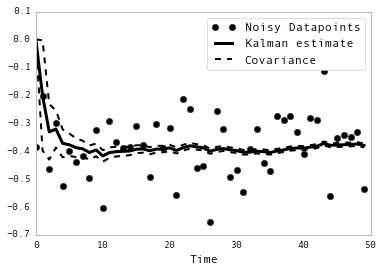

In [7]:
# The 1D Kalman filter

def Kalman(obs=None,mu_init=np.array([-0.37727]),cov_init=0.1*np.ones((1)),nsteps=50):

    ndim = np.shape(mu_init)[0]
    
    if obs==None:
        mu_init = np.tile(mu_init,(1,nsteps))
        cov_init = np.tile(cov_init,(1,nsteps))
        obs = np.random.normal(mu_init,cov_init,(ndim,nsteps))
    
    Sigma_x = np.eye(ndim)*1e-5
    A = np.eye(ndim)
    H = np.eye(ndim)
    mu_hat = 0
    cov = np.eye(ndim)
    R = np.eye(ndim)*0.01
    
    m = np.zeros((ndim,nsteps),dtype=float)
    ce = np.zeros((ndim,nsteps),dtype=float)
    
    for t in range(1,nsteps):
        # Make prediction
        mu_hat_est = np.dot(A,mu_hat)
        cov_est = np.dot(A,np.dot(cov,np.transpose(A))) + Sigma_x

        # Update estimate
        error_mu = obs[:,t] - np.dot(H,mu_hat_est)
        error_cov = np.dot(H,np.dot(cov,np.transpose(H))) + R
        K = np.dot(np.dot(cov_est,np.transpose(H)),np.linalg.inv(error_cov))
        mu_hat = mu_hat_est + np.dot(K,error_mu)
        #m[:,:,t] = mu_hat
        m[:,t] = mu_hat
        if ndim>1:
            cov = np.dot((np.eye(ndim) - np.dot(K,H)),cov_est)
        else:
            cov = (1-K)*cov_est 
        ce[:,t] = cov                                
    
    plt.figure()
    plt.plot(obs[0,:],'ko',ms=6)
    plt.plot(m[0,:],'k-',lw=3)
    plt.plot(m[0,:]+20*ce[0,:],'k--',lw=2)
    plt.plot(m[0,:]-20*ce[0,:],'k--',lw=2)
    plt.legend(['Noisy Datapoints','Kalman estimate','Covariance'])
    plt.xlabel('Time')
    
    
    plt.show()
    
Kalman()

In [10]:
def Kalman_update(A,H,Q,R,y,x,Sig,B=None,u=None):

    if B is None:
        xpred = np.dot(A,x) 
    else:
        xpred = np.dot(A,x) + np.dot(B,u)

    SigPred = np.dot(A,np.dot(Sig,A.T)) + Q

    e = y - np.dot(H,xpred)
    Sinv = np.linalg.inv(np.dot(H,np.dot(SigPred,H.T)) + R)
    K = np.dot(SigPred,np.dot(H.T,Sinv))

    xnew = xpred + np.dot(K,e)
    SigNew = np.dot((np.eye(np.shape(A)[0]) - np.dot(K,H)),SigPred)

    return xnew.T,SigNew
    
def Kalman_smoother_update(A,Q,B,u,xs_t,Sigs_t,xfilt,Sigfilt,Sigfilt_t):

    if B is None:
        xpred = np.dot(A,xfilt)
    else:
        xpred = np.dot(A,xfilt) + np.dot(B,u)

    SigPred = np.dot(A,np.dot(Sigfilt,A.T)) + Q
    J = np.dot(Sigfilt,np.dot(A.T,np.linalg.inv(SigPred)))
    xs = xfilt + np.dot(J,(xs_t - xpred))
    Sigs = Sigfilt + np.dot(J,np.dot((Sigs_t - SigPred),J.T))

    return xs.T, Sigs


def Kalman_filter(y,A,H,Q,R,x0,Sig0,B=None,u=None):

    obs_size,T = np.shape(y)
    state_size = np.shape(A)[0]

    x = np.zeros((state_size,T))
    Sig = np.zeros((state_size,state_size,T))

    [x[:,0],Sig[:,:,0]] = Kalman_update(A,H,Q,R,y[:,0].reshape(len(y),1),x0,Sig0,B,u)
    for t in range(1,T):
        prevx = x[:,t-1].reshape(state_size,1)
        prevSig = Sig[:,:,t-1]
        [x[:,t],Sig[:,:,t]] = Kalman_update(A,H,Q,R,y[:,t].reshape(len(y),1),prevx,prevSig,B,u)

    return x,Sig

def Kalman_smoother(y,A,H,Q,R,x0,Sig0,B=None,u=None):

    obs_size,T = np.shape(y)
    state_size = np.shape(A)[0]

    xs = np.zeros((state_size,T))
    Sigs = np.zeros((state_size,state_size,T))

    [xfilt,Sigfilt] = Kalman_filter(y,A,H,Q,R,x0,Sig0,B,u)

    xs[:,T-1] = xfilt[:,T-1]
    Sigs[:,:,T-1] = Sigfilt[:,:,T-1]

    for t in range(T-2,-1,-1):
        [xs[:,t],Sigs[:,:,t]] = Kalman_smoother_update(A,Q,B,u,xs[:,t+1].reshape(len(xs),1),Sigs[:,:,t+1],xfilt[:,t].reshape(len(xfilt),1),Sigfilt[:,:,t],Sigfilt[:,:,t+1])

    return xs,Sigs

def lds_sample(A,H,Q,R,state0,T):
    # x(t+1) = Ax(t) +  state_noise(t), state_noise ~ N(O,Q), x(0) = state0
    # y(t) = Hx(t) + obs_noise(t), obs_noise~N(O,R)

    state_noise_samples = np.random.multivariate_normal(np.zeros((len(Q))),Q,T).T
    obs_noise_samples = np.random.multivariate_normal(np.zeros((len(R))),R,T).T

    x = np.zeros((np.shape(H)[1],T))
    y = np.zeros((np.shape(H)[0],T))

    x[:,0] = state0.T
    y[:,0] = np.dot(H,x[:,0]) + obs_noise_samples[:,0]

    for t in range(1,T):
        x[:,t] = np.dot(A,x[:,t-1]) + state_noise_samples[:,t]
        y[:,t] = np.dot(H,x[:,t-1]) + obs_noise_samples[:,t]

    return [x,y]

def Kalman_demo():
    state_size = 4
    observation_size = 2
    A = np.array([[1,0,1,0],[0,1,0,1],[0,0,1,0],[0,0,0,1]],dtype=float)
    H = np.array([[1,0,0,0],[0,1,0,0]],dtype=float)

    Q = 0.1*np.eye((state_size))
    R = np.eye(observation_size,dtype=float)

    x0 = np.array([[10],[10],[1],[0]],dtype=float)
    Sig0 = 10. * np.eye(state_size)

    np.random.seed(3)
    T = 15
    
    [x,y] = lds_sample(A,H,Q,R,x0,T)

    [xfilt,Sigfilt] = Kalman_filter(y,A,H,Q,R,x0,Sig0)
    [xsmooth,Sigsmooth] = Kalman_smoother(y,A,H,Q,R,x0,Sig0)

    dfilt = x[[0,1],:] - xfilt[[0,1],:]
    mse_filt = np.sqrt(np.sum(dfilt**2))

    dsmooth = x[[0,1],:] - xsmooth[[0,1],:]
    mse_smooth = np.sqrt(np.sum(dsmooth**2))

    plot_track(x,y,xfilt,Sigfilt)
    plot_track(x,y,xsmooth,Sigsmooth)
    
def plot_track(x,y,Kx,Sig):
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    plt.plot(x[0,:],x[1,:],'ks-')
    plt.plot(y[0,:],y[1,:],'k*')
    plt.plot(Kx[0,:],Kx[1,:],'kx:')
    plt.legend(('True','Observed','Filtered'))

    obs_size,T = np.shape(y)

    from matplotlib.patches import Ellipse
    # Axes of ellipse are eigenvectors of covariance matrix, lengths are square roots of eigenvalues
    ellsize = np.zeros((obs_size,T))
    ellangle = np.zeros((T))
    for t in range(T):
        [evals,evecs] = np.linalg.eig(Sig[:2,:2,t])
        ellsize[:,t] = np.sqrt(evals)   
        ellangle[t] = np.angle(evecs[0,0]+0.j*evecs[0,1])
        
    ells = [Ellipse(xy=[Kx[0,t],Kx[1,t]] ,width=ellsize[0,t],height=ellsize[1,t], angle=ellangle[t]) for t in range(T)]
    for e in ells:
        ax.add_artist(e)
        e.set_alpha(0.1)
        e.set_facecolor([0.7,0.7,0.7])
    plt.xlabel('x')
    plt.ylabel('y')


def Kalman_demo1d():

    x0 = np.array([-0.37727])
    Sig0 = 0.1*np.ones((1))
    T = 50  

    y = np.random.normal(x0,Sig0,(1,T))

    A = np.eye(1)
    H = np.eye(1)
    Q = np.eye(1)*1e-5
    R = np.eye(1)*0.01

    xfilt = np.zeros((1,T),dtype=float)
    Sigfilt = np.zeros((1,T),dtype=float)

    [xfilt,Sigfilt] = Kalman_filter(y,A,H,Q,R,x0,Sig0)
    xfilt = np.squeeze(xfilt)
    Sigfilt = np.squeeze(Sigfilt)

    plt.figure()
    time = np.arange(T)
    plt.plot(time,y[0,:],'ko',ms=6)
    plt.plot(time,xfilt,'k-',lw=3)
    plt.plot(time,xfilt+20*Sigfilt,'k--',lw=2)
    plt.plot(time,xfilt-20*Sigfilt,'k--',lw=2)
    plt.legend(['Noisy Datapoints','Kalman estimate','20*Covariance'])
    plt.xlabel('Time')

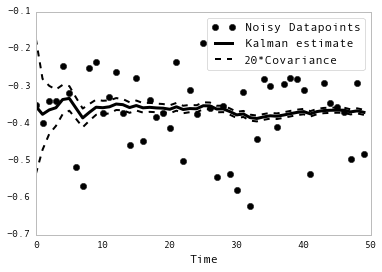

In [11]:
Kalman_demo1d()

In [13]:
def EKF_update(Q,R,y,x,t,Sig,B=None,u=None):

    if B is None:
        xpred = f(x,t).reshape(len(x),1)
    else:
        xpred = f(x,t).reshape(len(x),1) + np.dot(B,u)

    A = np.array(jac_f(x,t))
    #A = jac_f(x,t).reshape(1,len(x))
    SigPred = np.dot(A,np.dot(Sig,A.T)) + Q

    H = jac_h(xpred).reshape(1,len(x))
    e = y - h(xpred)
    Sinv = 1./(np.dot(H,np.dot(SigPred,H.T)) + R)
    #Sinv = np.linalg.inv(np.dot(H,np.dot(SigPred,H.T)) + R)
    K = np.dot(SigPred,np.dot(H.T,Sinv))

    xnew = xpred + np.dot(K,e)
    SigNew = np.dot((1 - np.dot(K,H)),SigPred)

    return xnew.T,SigNew
    
def EKF(y,Q,R,x0,Sig0,B=None,u=None):

    obs_size,T = np.shape(y)
    state_size = np.shape(Q)[0]

    x = np.zeros((state_size,T))
    Sig = np.zeros((state_size,state_size,T))

    [x[:,0],Sig[:,:,0]] = EKF_update(Q,R,y[:,0].reshape(len(y),1),x0,0,Sig0,B,u)
    for t in range(1,T):
        prevx = x[:,t-1].reshape(state_size,1)
        prevSig = Sig[:,:,t-1]
        [x[:,t],Sig[:,:,t]] = EKF_update(Q,R,y[:,t].reshape(len(y),1),prevx,t,prevSig,B,u)

    return x,Sig

def f(x,t):
    return np.array([x[1],x[2],0.5*x[0]*(x[1]+x[2])]).T

def jac_f(x,t):
    return np.array([[0,0,0.5*(x[1]+x[2])],[1,0,0.5*x[0]],[0,1,0.5*x[0]]])
    #return x

def jac_h(x):
    #return np.array([x[2]*np.sin(x[0]), 0, np.cos(x[0])])
    return np.array([1.0,1.0,0.0]) #np.array([0.4*x]).reshape(1,1)
    #return np.array([1.0,0.0,0.0]) #np.array([0.4*x]).reshape(1,1)

def h(x):
    return x[0]+x[1]

def EKF_demo():

    state_size = 3
    observation_size = 1

    Q = 0.1*np.eye(state_size)
    R = 0.1*np.eye(observation_size)
    x0 = np.array([0,0,1])
    Sig0 = np.eye(state_size)
    
    T = 20
    state = np.zeros((state_size,T))
    y = np.zeros((observation_size,T))
    state[:,0] = x0.T

    for t in range(1,T):
        state[:,t] = f(state[:,t-1],t) + np.random.multivariate_normal(np.zeros((len(Q))),Q)
        y[:,t] = h(state[:,t]) + np.sqrt(R)*np.random.randn()
        #state[:,t] = np.dot(A,state[:,t-1]) + np.random.multivariate_normal(np.zeros((len(Q))),Q)
        #y[:,t] = h(state[:,t]) + np.random.randn()

    [xfilt,Sigfilt] = EKF(y,Q,R,x0,Sig0)

    dfilt = state[0,:] - xfilt[0,:]
    #dfilt = state[[0,1],:] - xfilt[[0,1],:]
    mse_filt = np.sqrt(np.sum(dfilt**2))
    print(mse_filt)

    ypred = np.zeros((T))
    for t in range(T):
        ypred[t] = h(xfilt[:,t])

    print(Sigfilt)
    plt.figure()
    plt.plot(np.arange(T),np.squeeze(y),'*')
    plt.plot(np.arange(T),ypred,'k-')
    

Particle filter

In [15]:
def systematic(w,N):
    # Systematic resampling
    N2 = np.shape(w)[0]
    # One too many to make sure it is >1
    samples = np.random.rand(N+1)
    indices = np.arange(N+1)
    u = (samples+indices)/(N+1) 
    cumw = np.cumsum(w)
    keep = np.zeros((N))
    # ni copies of particle xi where ni = number of u between ws[i-1] and ws[i]
    j = 0
    for i in range(N2):
        while((u[j]<cumw[i]) & (j<N)):
            keep[j] = i
            j+=1

    return keep

def pf(x,y,sigma,T,N):

    particles = np.ones((N,T))
    particlepred = np.ones((N,T))
    ypred = np.ones((N,T))
    weights = np.ones((N,T))

    # Main loop
    for t in range(1,T):
    
        # importance sampling
        particlepred[:,t] = ffun(particles[:,t-1],t) + np.random.randn(N)
        ypred[:,t] = hfun(particlepred[:,t],t)
        weights[:,t] = 1./np.sqrt(sigma) * np.exp(-0.5/sigma * (y[t] - ypred[:,t])**2) + 1e-99
        weights[:,t] /= np.sum(weights[:,t])
        
        # selection
        sys= True
        if sys:
            keep = systematic(weights[:,t],N)
        else:   
            # Residual resampling
            # Add a little bit because of a rounding error!
            Ncopies = np.floor(weights[:,t]*N + 1e-10)
            keep = np.zeros((N))
            j = 0
            for i in range(N):
                keep[j:j+Ncopies[i]] = i
                j+=Ncopies[i]
                
            Nleft = int(N - np.sum(Ncopies))
            # Rest by systematic resampling
            if Nleft > 0:
                print("sys resample")
                probs = (weights[:,t]*N - Ncopies)/Nleft
                extrakeep = systematic(probs,Nleft)
                keep[j:] = extrakeep
        
        particles[:,t] = particlepred[keep.astype('int'),t]

    return particles, particlepred, ypred, weights

def ffun(x,t):
    return 1 + np.sin(4e-2*np.pi*t) + 0.5*x

def hfun(x,t):
    if t<30:
        return x**2/5.0
    else:
        return x/2. - 2.

def pf_demo():

    T = 50
    N = 10  
    sigma = 1.0
    
    x = np.zeros((T))
    x[1] = 1
    y = np.zeros((T))
    for t in range(T):
        x[t] = ffun(x[t-1],t) + np.random.randn(1)
        y[t] = hfun(x[t],t) + np.sqrt(sigma)*np.random.randn(1,1)

    p, pp, yp, w = pf(x,y,sigma,T,N)

    plt.figure()
    time = np.arange(T)
    plt.plot(time,y,'k+')
    plt.plot(time,x,'k:')
    #plt.plot(time,np.mean(p,axis=0),'.')
    plt.plot(time[:30],hfun(np.mean(p,axis=0)[:30],0),'k')
    plt.plot(time,p.T,'k.')
    plt.plot(time[30:],hfun(np.mean(p,axis=0)[30:],40),'k')
    #plt.axis([-0.5,9.5,-1,7])
    plt.legend(['Observation','Process','Output','Particles'])


In [19]:
# 2D particle filter tracking. Euclidean distance based

def systematic(w,N):
    # Systematic resampling
    # One too many to make sure it is >1
    samples = np.random.rand(N+1)
    indices = np.arange(N+1)
    u = (samples+indices)/N 
    cumw = np.cumsum(w)
    Ncopies = np.zeros((N))
    keep = np.zeros((N))
    # ni copies of particle xi where ni = number of u between ws[i-1] and ws[i]
    j = 0
    for i in range(N):
        while((u[j]<cumw[i]) & (j<N)):
            keep[j] = i
            Ncopies[i]+=1
            j+=1

    return keep

def pf(x0,xdot,sigma,T,N,width):

    # Sample x0 from prior p(x0)
    particles = np.zeros((N,2,T+1))
    x = np.zeros((2,T+1))
    x[:,0] = x0
    particles[:,:,0] = x0
    particlepred = np.zeros((N,2,T))
    particlepred[:,:,0] = x0+np.random.uniform(-width,width,(N,2))
    print(particlepred[:,:,0])
    weights = np.ones((N,T))

    # Main loop
    for t in range(0,T):
    
        # importance sampling
        particlepred[:,:,t] = particles[:,:,t] + np.random.uniform(-width,width,(N,2))
        #print particlepred[:,:,t]

        print(x[:,t])
        print(x[:,t] - particlepred[:,:,t])
        weights[:,t] = np.sum((x[:,t] - particlepred[:,:,t])**2 + 1e-99,axis=1)
        print(weights[:,t])
        weights[:,t] = 1./np.sum((x[:,t] - particlepred[:,:,t])**2 + 1e-99,axis=1)
        print(weights[:,t])
        #weights[:,t] = np.sum(1./np.sqrt(sigma) * np.exp(-0.5/sigma * (x[:,t] - particlepred[:,:,t])**2) + 1e-99,axis=1)
        weights[:,t] /= np.sum(weights[:,t])
        print(weights[:,t])
        
        # selection
        resample = False
        if 1./sum(weights[:,t]**2) < N/2.:
            print("Resampling")
            resample = True
        sys= True
        if resample:
            if sys:
                keep = systematic(weights[:,t],N)
            else:   
                # Residual resampling
                # Add a little bit because of a rounding error!
                Ncopies = np.floor(weights[:,t]*N + 1e-10)
                keep = np.zeros((N))
                j = 0
                for i in range(N):
                    keep[j:j+Ncopies[i]] = i
                    j+=Ncopies[i]
                    
                Nleft = int(N - np.sum(Ncopies))
                # Rest by systematic resampling
                if Nleft > 0:
                    print("sys resample")
                    probs = (weights[:,t]*N - Ncopies)/Nleft
                    extrakeep = systematic(probs,Nleft)
                    keep[j:] = extrakeep
        else:
            keep = range(N)
    
        print(keep)
        # output
        for i in range(N):
            particles[i,:,t+1] = particlepred[keep[i],:,t]
            #print "here"
        print(x[:,t])
        print(particlepred[:,:,t])
        #x[:,t+1] = x[:,t] + xdot*np.random.uniform(-1,1,(1,2))
        x[:,t+1] = x[:,t] + xdot #+ np.random.uniform(-1,1,(1,2))
        #print particles[:,:,t]

    return particles, x,weights

def pf_demo():

    x0 = np.array([10,12])
    xdot = np.array([10,8])

    np.random.seed(3)
    T = 15
    N = 30
    sigma = 1.0

    [particles,x,weights] = pf(x0,xdot,sigma,T,N,15)
    x = x[:,:T]
    particles = particles[:,:,:T]
    #print particles
    #print x

    dfilt = x[[0,1],:] - particles[[0,1],:]
    mse_filt = np.sqrt(np.sum(dfilt**2))

    #plot_track(x,y,xfilt,Pfilt)
    plot_position(x,particles,T)
    
def plot_position(x,particles,T):
    import time

    plt.ion()
    plt.figure()
    colours = plt.cm.gray(np.linspace(0, 1, T))

    #for t in [0,5,10,14]:
    for t in range(T):
        #print particles[:,:,t]
        plt.plot(x[0,t],x[1,t],'x',color=colours[t],ms=10.)
        plt.plot(particles[:,0,t],particles[:,1,t],'o',color=colours[t])
    #plt.plot(particles[:,0,5],particles[:,1,5],'go')
    #plt.plot(particles[:,0,10],particles[:,1,10],'co')
    #plt.plot(particles[:,0,14],particles[:,1,14],'ko')
    plt.xlim((0,150))
    plt.ylim((0,150))

def plot_track(x,y,Kx,P):
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    plt.plot(x[0,:],x[1,:],'ks-')
    plt.plot(y[0,:],y[1,:],'k*')
    plt.plot(Kx[0,:],Kx[1,:],'kx:')

    obs_size,T = np.shape(y)

    from matplotlib.patches import Ellipse
    # Axes of ellipse are eigenvectors of covariance matrix, lengths are square roots of eigenvalues
    ellsize = np.zeros((obs_size,T))
    ellangle = np.zeros((T))
    for t in range(T):
        [evals,evecs] = np.linalg.eig(P[:2,:2,t])
        ellsize[:,t] = np.sqrt(evals)   
        ellangle[t] = np.angle(evecs[0,0]+0.j*evecs[0,1])
        
    ells = [Ellipse(xy=[Kx[0,t],Kx[1,t]] ,width=ellsize[0,t],height=ellsize[1,t], angle=ellangle[t]) for t in range(T)]
    for e in ells:
        ax.add_artist(e)
        e.set_alpha(0.1)
        e.set_facecolor([0.7,0.7,0.7])

[[ 11.52393708  18.24443468]
 [  3.72714217  12.32482816]
 [ 21.78840863  23.88879267]
 [ -1.23244069   3.21728634]
 [ -3.4559839   10.22429531]
 [ -4.10371367  10.70499673]
 [ 14.47432143   5.35461848]
 [ 15.28764706  14.72588452]
 [ -4.28054353  13.76562264]
 [  2.77757341   9.45303591]
 [  3.50575245  17.79413755]
 [  8.21361153   1.70603215]
 [ 11.33947054  20.40944294]
 [  4.19090597   3.65873652]
 [  6.63913773  25.0915095 ]
 [ 24.27986267  17.17151028]
 [ 22.08502326  22.37252614]
 [  6.33982124  -0.23348973]
 [ 14.60232708  13.73522287]
 [  5.84694289   3.75163515]
 [  7.19559749  11.06820746]
 [  3.07706735   5.75378323]
 [  8.73059198  22.81601739]
 [ 12.58758713   5.50463587]
 [  3.3393252   10.63866227]
 [  1.16231034   3.04136133]
 [ 10.42105179  -0.38311894]
 [  9.50756597   7.86528637]
 [ 16.23059865  19.40238669]
 [ 15.73278766  17.67541241]]
[ 10.  12.]
[[  3.79199628  -5.04404414]
 [  4.80454008  -2.1838161 ]
 [  5.22578526   1.64564852]
 [ 13.15413208   7.71973733]
 

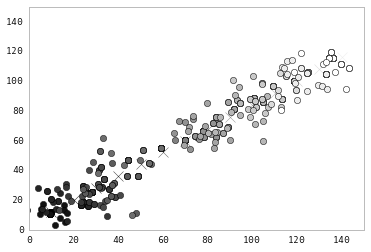

In [20]:
pf_demo()

## References

S. Marsland. (2009) [Machine Learning: An Algorithmic Perspective](Machine Learning: An Algorithmic Perspectivehttp://seat.massey.ac.nz/personal/s.r.marsland/MLBook.html). CRC Press.

---

In [3]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()